# Clasificación de patrones

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LDA" data-toc-modified-id="LDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LDA</a></span><ul class="toc-item"><li><span><a href="#Gráfico-del-conjunto-de-entrenamiento-y-test" data-toc-modified-id="Gráfico-del-conjunto-de-entrenamiento-y-test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Gráfico del conjunto de entrenamiento y test</a></span></li><li><span><a href="#Obtención-de-los-parámetros-de-las-funciónes-de-probabilidad-del-modelo" data-toc-modified-id="Obtención-de-los-parámetros-de-las-funciónes-de-probabilidad-del-modelo-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Obtención de los parámetros de las funciónes de probabilidad del modelo</a></span></li><li><span><a href="#Puesta-a-prueba-del-clasificador" data-toc-modified-id="Puesta-a-prueba-del-clasificador-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Puesta a prueba del clasificador</a></span></li></ul></li><li><span><a href="#Clasificación-no-supervizada" data-toc-modified-id="Clasificación-no-supervizada-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clasificación no supervizada</a></span><ul class="toc-item"><li><span><a href="#K-means" data-toc-modified-id="K-means-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>K-means</a></span></li><li><span><a href="#E-M" data-toc-modified-id="E-M-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>E-M</a></span></li></ul></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.stats as sd 

def elipse_from_mvariance(variance,radius=1):
    """Calcula los coeficientes x e y para plotear una elipse"""
    [[a11,a12],[a21,a22]]=np.linalg.inv(variance)
    x_lim=np.sqrt(-4*a22*radius**2/(-4*a11*a22+4*a12**2))
    x1=np.linspace(-x_lim,x_lim,1000)
    x2=x1[::-1]
    y1=(-2*x1*a12+np.sqrt((2*x1*a12)**2-4*a22*((x1**2)*a11-radius**2)))/2/a22
    y2=(-2*x2*a12-np.sqrt((2*x2*a12)**2-4*a22*((x2**2)*a11-radius**2)))/2/a22
    x=np.hstack((x1,x2))
    y=np.hstack((y1,y2))
    return x, y

    

## LDA
### Gráfico del conjunto de entrenamiento y test

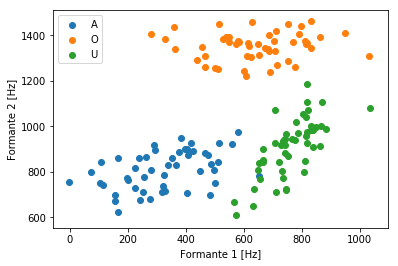

In [2]:
# carga de los formantes
formantes_a=np.genfromtxt('c1.txt',delimiter='\t')
formantes_a=formantes_a[:,0:2]
formantes_o=np.genfromtxt('c2.txt',delimiter='\t')
formantes_o=formantes_o[:,0:2]
formantes_u=np.genfromtxt('c3.txt',delimiter='\t')
formantes_u=formantes_u[:,0:2]
# gráfico
fig,ax1=plt.subplots()
ax1.scatter(formantes_a[:,0],formantes_a[:,1])
ax1.scatter(formantes_o[:,0],formantes_o[:,1])
ax1.scatter(formantes_u[:,0],formantes_u[:,1])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')
ax1.legend(('A','O','U'))

### Obtención de los parámetros de las funciónes de probabilidad del modelo

/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


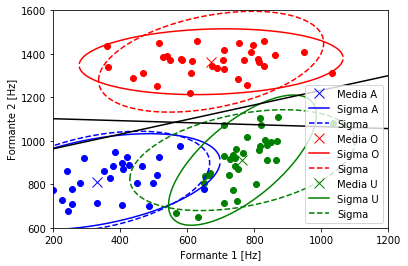

In [3]:
# Separo el conjunto de entrenamiento del de test
test_size=17
a_ent=formantes_a[:-test_size,:]
o_ent=formantes_o[:-test_size,:]
u_ent=formantes_u[:-test_size,:]
# Calculo la cantidad de muestras en cada categoría
N_a=np.size(a_ent,axis=0)
N_o=np.size(o_ent,axis=0)
N_u=np.size(u_ent,axis=0)
N=N_a+N_o+N_u
# Calculo los parametros
# para la A,
P_a=N_a/N
mu_a=1/N_a*np.sum(a_ent,axis=0)
mu_a=mu_a.reshape(2,1)
sigma_a=np.dot(a_ent.T,a_ent)/N_a-np.dot(mu_a,mu_a.T)
# para la O,
P_o=N_o/N
mu_o=1/N_o*np.sum(o_ent,axis=0)
mu_o=mu_o.reshape(2,1)
sigma_o=np.dot(o_ent.T,o_ent)/N_o-np.dot(mu_o,mu_o.T)
# para la U,
P_u=N_u/N
mu_u=1/N_u*np.sum(u_ent,axis=0)
mu_u=mu_u.reshape(2,1)
sigma_u=np.dot(u_ent.T,u_ent)/N_u-np.dot(mu_u,mu_u.T)
# y Sigma
sigma=(np.dot(a_ent.T,a_ent)+np.dot(o_ent.T,o_ent)+np.dot(u_ent.T,u_ent)
      -N_a*np.dot(mu_a,mu_a.T)-N_o*np.dot(mu_o,mu_o.T)-N_u*np.dot(mu_u,mu_u.T))/N
sigma_inv=np.linalg.inv(sigma)

# Guardo los parametros obtenidos
LDA_mean=np.dstack((mu_a,mu_o,mu_u))
LDA_sigma=np.dstack((sigma_a,sigma_o,sigma_u))

# Rectas de separación
# Calculo de los X_0 de la función g
X_a = np.log(P_a) - .5 * np.dot(mu_a.T, np.dot(sigma_inv, mu_a))
X_o = np.log(P_o) - .5 * np.dot(mu_o.T, np.dot(sigma_inv, mu_o))
X_u = np.log(P_u) - .5 * np.dot(mu_u.T, np.dot(sigma_inv, mu_u))
# Calculo de los Vt de la función g
V1_a, V2_a = np.dot(mu_a.T, sigma_inv[:,0]), np.dot(mu_a.T, sigma_inv[:,1])
V1_o, V2_o = np.dot(mu_o.T, sigma_inv[:,0]), np.dot(mu_o.T, sigma_inv[:,1])
V1_u, V2_u = np.dot(mu_u.T, sigma_inv[:,0]), np.dot(mu_u.T, sigma_inv[:,1])
# Calculo de las rectas de decisión
m_ao = (V1_o - V1_a) / (V2_a - V2_o)
m_au = (V1_u - V1_a) / (V2_a - V2_u)
m_ou = (V1_u - V1_o) / (V2_o - V2_u)
b_ao = (X_o - X_a) / (V2_a - V2_o)
b_au = (X_u - X_a) / (V2_a - V2_u)
b_ou = (X_u - X_o) / (V2_o - V2_u)


# Gráfico
fig,ax1=plt.subplots()
# Para A
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma_a,radio_elipse)
ax1.plot(mu_a[0,0],mu_a[1,0],'xb',markersize=10)
ax1.plot(x+mu_a[0,0],y+mu_a[1,0],'b')
ax1.scatter(a_ent[:,0],a_ent[:,1],color='b')
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma,radio_elipse)
ax1.plot(x+mu_a[0,0],y+mu_a[1,0],'b--')

# Para O
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma_o,radio_elipse)
ax1.plot(mu_o[0,0],mu_o[1,0],'xr',markersize=10)
ax1.plot(x+mu_o[0,0],y+mu_o[1,0],'r')
ax1.scatter(o_ent[:,0],o_ent[:,1],color='r')
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma,radio_elipse)
ax1.plot(x+mu_o[0,0],y+mu_o[1,0],'r--')

# Para U
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma_u,radio_elipse)
ax1.plot(mu_u[0,0],mu_u[1,0],'xg',markersize=10)
ax1.plot(x+mu_u[0,0],y+mu_u[1,0],'g')
ax1.scatter(u_ent[:,0],u_ent[:,1],color='g')
radio_elipse=2.5
x,y=elipse_from_mvariance(sigma,radio_elipse)
ax1.plot(x+mu_u[0,0],y+mu_u[1,0],'g--')

# Rectas de decisión
x=np.linspace(0,1500,1000)
y=m_ao * x + b_ao
ax1.plot(x,y[0,:],'k')
y=m_au * x + b_au
#ax1.plot(x,y[0,:],'k') # Esta la comento porque g_o > g_a ^ g_u en la región donde esta esa recta
y=m_ou * x + b_ou
ax1.plot(x,y[0,:],'k')

# Formato
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')
ax1.legend(('Media A','Sigma A','Sigma','Media O','Sigma O','Sigma','Media U','Sigma U','Sigma'))

Se puede ver en el grafico que ya hay errores incluso para el conjunto de entrenamiento.
### Puesta a prueba del clasificador

Text(0,0.5,'Formante 2 [Hz]')

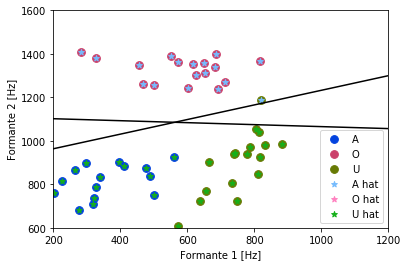

In [4]:
# clasificador
formantes_test=np.vstack((formantes_a[-test_size:,:],formantes_o[-test_size:,:],formantes_u[-test_size:,:]))
a,o,u = np.empty([1,2]),np.empty([1,2]),np.empty([1,2]) # estos valores iniciales no se van a usar

# hago la clasificación en base a las rectas de decisión
# esto puede no funcionar para cualquier conjunto de muestras
# porque puede cambiar el signo de la pendiente y las condiciones
# de contorno cambian ('>' cambia por '<')
for i in range(np.size(formantes_test,axis=0)):                                             
    if formantes_test[i,1] > (m_ao * formantes_test[i,0] + b_ao): 
        a=np.vstack((a,formantes_test[i,:]))
    else:
        if formantes_test[i,1] > (m_ou * formantes_test[i,0] + b_ou):
            o=np.vstack((o,formantes_test[i,:]))
        else:
            u=np.vstack((u,formantes_test[i,:]))

# Gráfico
fig,ax1=plt.subplots()
ax1.scatter(formantes_a[-test_size:,0],formantes_a[-test_size:,1],s=60,color='xkcd:blue',marker='o')
ax1.scatter(formantes_o[-test_size:,0],formantes_o[-test_size:,1],s=60,color='xkcd:dark pink',marker='o')
ax1.scatter(formantes_u[-test_size:,0],formantes_u[-test_size:,1],s=60,color='xkcd:olive green',marker='o')

ax1.scatter(a[1:,0],a[1:,1],marker='*',color='xkcd:sky blue')
ax1.scatter(o[1:,0],o[1:,1],marker='*',color='xkcd:pink')
ax1.scatter(u[1:,0],u[1:,1],marker='*',color='xkcd:green')

ax1.legend(('A','O','U','A hat','O hat','U hat'))

# Rectas de decisión
x=np.linspace(0,1500,1000)
y=m_ao * x + b_ao
ax1.plot(x,y[0,:],'k')
y=m_ou * x + b_ou
ax1.plot(x,y[0,:],'k')

# Formato
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')

Hay dos errores en la clasificación de la A. Son 2 errores en 51 muestras, Pe$\simeq$4%

## Clasificación no supervizada
### K-means

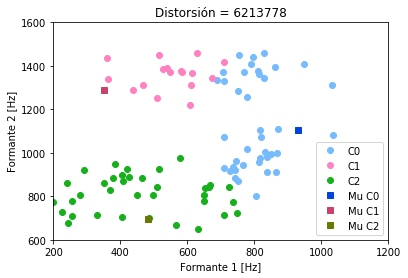

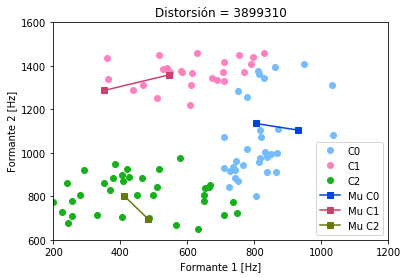

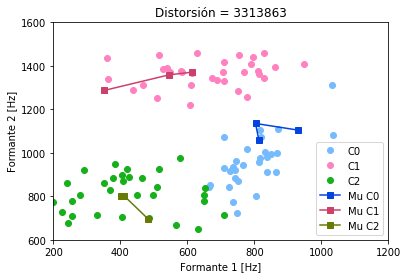

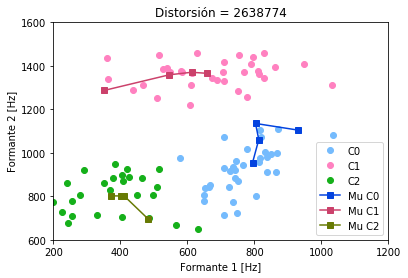

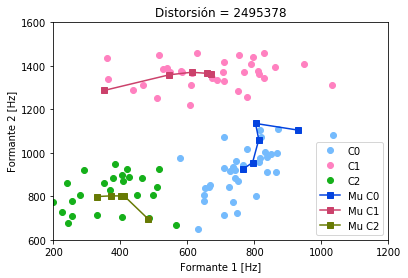

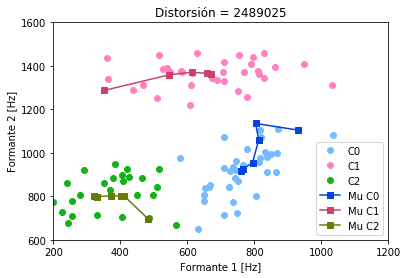

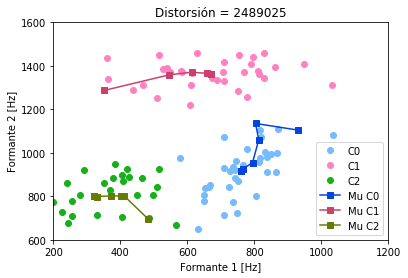

In [5]:
# Creación del vector de datos de entrenamiento
test_size=17
formantes_random=np.vstack((formantes_a[:-test_size,:],formantes_o[:-test_size,:],formantes_u[:-test_size,:]))
formantes_random=np.random.permutation(formantes_random)
train_size = np.size(formantes_random,axis=0)
formantes_random.reshape([train_size,2])

# Semillas
# Semilla random: se calcula la media muestral del total y se ubican las medias una distancia igual a radio
# a 120° cada una, con un angulo inicial al azar
radio=350
media_total=np.sum(formantes_random,axis=0)/train_size
angulo_inicial=np.random.rand(1)*2*np.pi/3
semilla_random=np.array([[0, 2*np.pi/3, 4*np.pi/3],[1,1,1]])
semilla_random[1,:]=semilla_random[1,:]*radio
semilla_random[0,:]=semilla_random[0,:]+angulo_inicial
semilla_random=np.array([semilla_random[1,:]*np.cos(semilla_random[0,:]),
                         semilla_random[1,:]*np.sin(semilla_random[0,:])])
semilla_random=semilla_random+np.reshape(np.array([media_total]),[2,1])*np.array([[1,1,1]])

# Semilla 'bootstrap': se hace con un pequeño conjunto de muestras del cual es conocida su categoría
eleccion=np.random.choice(np.int(train_size/3),3,False)
semilla_media_pequeña=np.array([np.sum(formantes_a[eleccion],axis=0)/3,
                                np.sum(formantes_o[eleccion],axis=0)/3,np.sum(formantes_u[eleccion],axis=0)/3])
semilla_media_pequeña=semilla_media_pequeña.T

# Algoritmo K-means
# Datos iniciales
k_mean = np.copy(semilla_random) # acá poner la semilla que se quiera usar
unos = np.reshape(np.ones(3),[1,3])
Dj = 0
D_ant = 0
c = np.zeros(train_size)
k_means = np.copy(k_mean)

# Clasificador primera iteración
for i in range(train_size):
    d = np.reshape(formantes_random[i],[2,1]) * unos - k_mean
    d = d[0,:]**2 + d[1,:]**2
    c[i] = np.argmin(d)
    Dj += d[int(c[i])]
Djs=np.copy(Dj)
# Gráfico primera iteración
fig, ax1 = plt.subplots()
ax1.plot(formantes_random[c==0,0],formantes_random[c==0,1],'o',color='xkcd:sky blue')
ax1.plot(formantes_random[c==1,0],formantes_random[c==1,1],'o',color='xkcd:pink')
ax1.plot(formantes_random[c==2,0],formantes_random[c==2,1],'o',color='xkcd:green')
ax1.plot(k_mean[0,0],k_mean[1,0],'s',color='xkcd:blue')
ax1.plot(k_mean[0,1],k_mean[1,1],'s',color='xkcd:dark pink')
ax1.plot(k_mean[0,2],k_mean[1,2],'s',color='xkcd:olive green')
# Formato
ax1.set_title('Distorsión = %d'%Dj)
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')
ax1.legend(('C0','C1','C2','Mu C0','Mu C1','Mu C2'))

# Siguientes ciclos
while Dj != D_ant:
    # Calculo del centroide
    n_class=np.zeros([3,2])
    k_mean=np.zeros([2,3])
    for i in range(train_size):
        k_mean[:,int(c[i])] += formantes_random.T[:,i]
        n_class[int(c[i])] += np.ones([2,])
    k_mean = k_mean/n_class.T
    k_means=np.dstack((k_means,k_mean))
    D_ant = np.copy(Dj)
    Dj = 0
    # Clasificador
    for i in range(train_size):
        d = np.reshape(formantes_random[i],[2,1]) * unos - k_mean
        d = d[0,:]**2 + d[1,:]**2
        c[i] = np.argmin(d)
        Dj += d[int(c[i])]
    Djs = np.hstack((Djs,Dj))
    # Gráfico por iteración --- Destabular si solo se quiere ver al final
    fig, ax1 = plt.subplots()
    ax1.plot(formantes_random[c==0,0],formantes_random[c==0,1],'o',color='xkcd:sky blue')
    ax1.plot(formantes_random[c==1,0],formantes_random[c==1,1],'o',color='xkcd:pink')
    ax1.plot(formantes_random[c==2,0],formantes_random[c==2,1],'o',color='xkcd:green')
    ax1.plot(k_means[0,0,:],k_means[1,0,:],'-s',color='xkcd:blue')
    ax1.plot(k_means[0,1,:],k_means[1,1,:],'-s',color='xkcd:dark pink')
    ax1.plot(k_means[0,2,:],k_means[1,2,:],'-s',color='xkcd:olive green')
    ax1.legend(('C0','C1','C2','Mu C0','Mu C1','Mu C2'))
    # Formato
    ax1.set_title('Distorsión = %d'%Dj)
    ax1.set_xlim([200,1200])
    ax1.set_ylim([600,1600])
    ax1.set_xlabel('Formante 1 [Hz]')
    ax1.set_ylabel('Formante 2 [Hz]')
# veo a que letra pertenece cada clase



Text(0.5,1,'Distorsión por iteraciones')

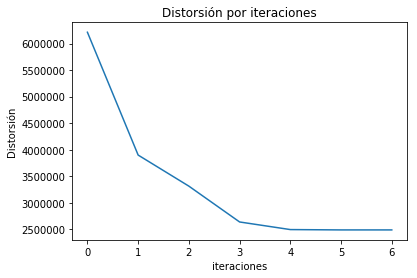

In [6]:
fig,ax1 = plt.subplots()
ax1.plot(Djs)
ax1.set_ylabel('Distorsión')
ax1.set_xlabel('iteraciones')
ax1.set_title('Distorsión por iteraciones')

La probabilidad de error estimada es de 0.058824


/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Text(0,0.5,'Formante 2 [Hz]')

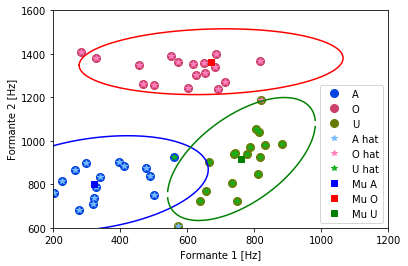

In [7]:
# Separo las muestras en categorías
a_ent=formantes_random[c==0,:]
o_ent=formantes_random[c==1,:]
u_ent=formantes_random[c==2,:]
# Calculo la cantidad de muestras en cada categoría
N_a=np.size(a_ent,axis=0)
N_o=np.size(o_ent,axis=0)
N_u=np.size(u_ent,axis=0)
N=N_a+N_o+N_u
# Calculo los parámetros
# para la A, (Basicamente copié y pegué lo de arriba. Como es no supervisado, no necesariamente va ser una A)
P_a=N_a/N
mu_a=k_mean[:,0]
mu_a=mu_a.reshape(2,1)
sigma_a=np.dot(a_ent.T,a_ent)/N_a-np.dot(mu_a,mu_a.T)
# para la O,
P_o=N_o/N
mu_o=k_mean[:,1]
mu_o=mu_o.reshape(2,1)
sigma_o=np.dot(o_ent.T,o_ent)/N_o-np.dot(mu_o,mu_o.T)
# para la U,
P_u=N_u/N
mu_u=k_mean[:,2]
mu_u=mu_u.reshape(2,1)
sigma_u=np.dot(u_ent.T,u_ent)/N_u-np.dot(mu_u,mu_u.T)

# Armo un vector con los sigmas
# Tener en cuenta que si se usa la distancia para categorizar las muestras el sigma de la distribución
# que modela las muestras es una matriz diagonal y los conjuntos de nivel son círculos
KM_sigma=np.dstack((sigma_a,sigma_o,sigma_u))

# Puesta a prueba de las medias obtenidas
formantes_test=np.vstack((formantes_a[-test_size:,:],formantes_o[-test_size:,:],formantes_u[-test_size:,:]))
c_test=np.zeros(test_size*3)
Dj=0
for i in range(test_size*3):
    d = np.reshape(formantes_test[i],[2,1]) * unos - k_mean
    d = d[0,:]**2 + d[1,:]**2
    c_test[i] = np.argmin(d)
    Dj += d[int(c_test[i])]

# Error
# Para poder ponerle una etiqueta a las muestras voy a usar los resultados que obtuve en LDA.
# Para ordenar las muestras me fijo cual esta mas cerca del valor que obtuve en LDA
orden=np.array((np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_a*unos,axis=0)),
               np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_o*unos,axis=0)),
               np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_u*unos,axis=0))))
Pe=(np.sum(c_test[:test_size]!=orden[0])+
    np.sum(c_test[test_size:test_size*2]!=orden[1])+
    np.sum(c_test[test_size*2:test_size*3]!=orden[2])) /test_size/3
print('La probabilidad de error estimada es de %f'%Pe)    
    
# Grafico final
fig, ax1 = plt.subplots()
ax1.plot(formantes_test[:test_size,0],formantes_test[:test_size,1],'o',markersize=8,color='xkcd:blue')
ax1.plot(formantes_test[test_size:test_size*2,0],formantes_test[test_size:test_size*2,1],'o',markersize=8,color='xkcd:dark pink')
ax1.plot(formantes_test[test_size*2:test_size*3,0],formantes_test[test_size*2:test_size*3,1],'o',markersize=8,color='xkcd:olive green')
ax1.plot(formantes_test[c_test==orden[0],0],formantes_test[c_test==orden[0],1],'*',color='xkcd:sky blue')
ax1.plot(formantes_test[c_test==orden[1],0],formantes_test[c_test==orden[1],1],'*',color='xkcd:pink')
ax1.plot(formantes_test[c_test==orden[2],0],formantes_test[c_test==orden[2],1],'*',color='xkcd:green')
ax1.plot(k_mean[0,orden[0]],k_mean[1,orden[0]],'sb')
ax1.plot(k_mean[0,orden[1]],k_mean[1,orden[1]],'sr')
ax1.plot(k_mean[0,orden[2]],k_mean[1,orden[2]],'sg')
# Elipses
radio_elipse=2.5
x,y=elipse_from_mvariance(KM_sigma[:,:,orden[0]],radio_elipse)
ax1.plot(x+k_mean[0,orden[0]],y+k_mean[1,orden[0]],'b')
x,y=elipse_from_mvariance(KM_sigma[:,:,orden[1]],radio_elipse)
ax1.plot(x+k_mean[0,orden[1]],y+k_mean[1,orden[1]],'r')
x,y=elipse_from_mvariance(KM_sigma[:,:,orden[2]],radio_elipse)
ax1.plot(x+k_mean[0,orden[2]],y+k_mean[1,orden[2]],'g')

# Formato
ax1.legend(('A','O','U','A hat','O hat','U hat','Mu A','Mu O','Mu U'))
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')

### E-M

/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


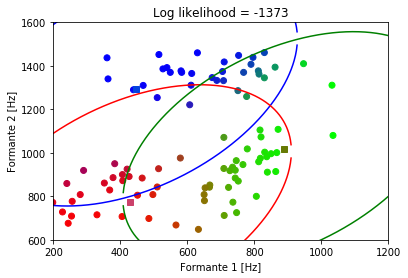

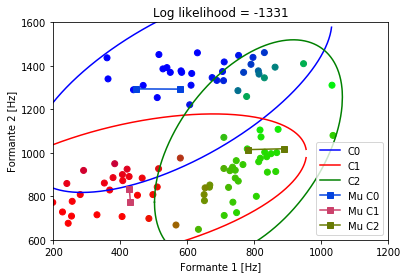

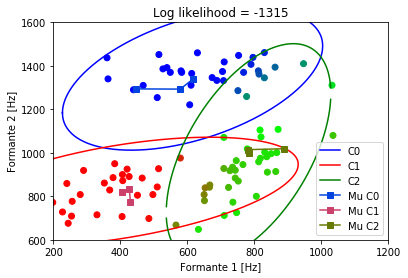

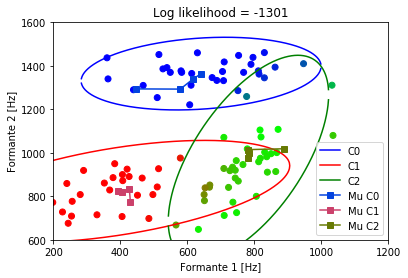

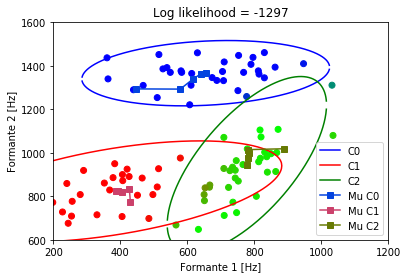

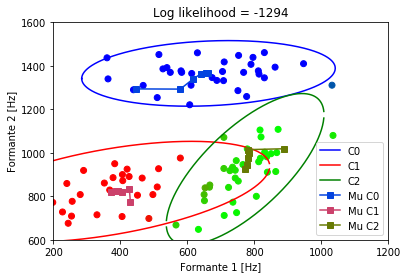

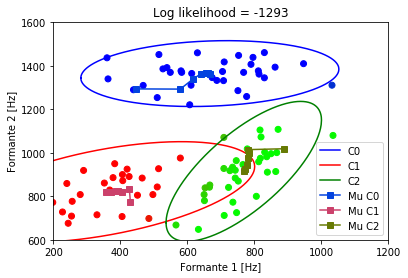

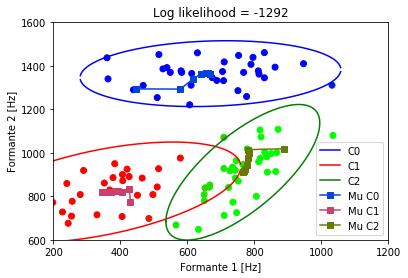

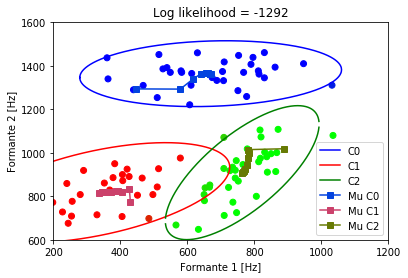

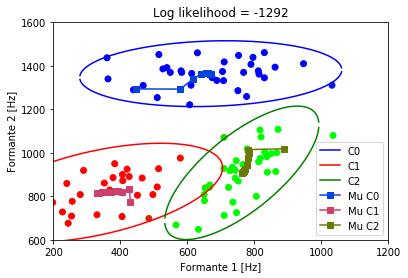

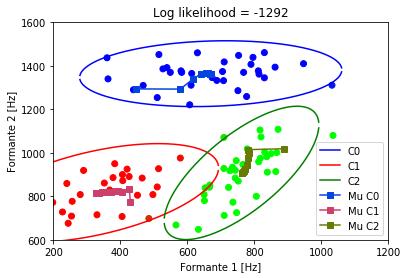

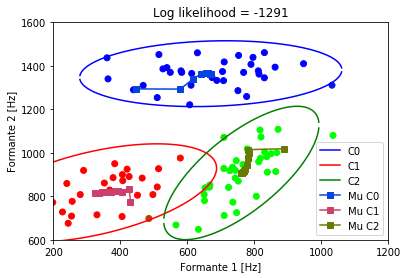

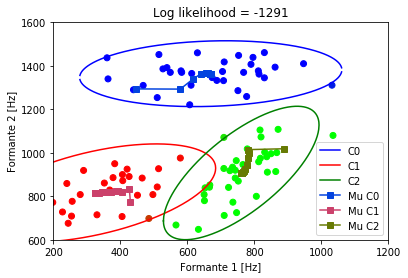

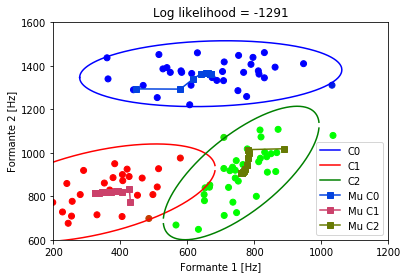

In [8]:
# Semillas
# Semilla random: se calcula la media muestral del total y se ubican las medias una distancia igual a radio
# a 120° cada una, con un angulo inicial al azar
radio=300
media_total=np.sum(formantes_random,axis=0)/train_size
angulo_inicial=np.random.rand(1)*2*np.pi/3
semilla_random=np.array([[0, 2*np.pi/3, 4*np.pi/3],[1,1,1]])
semilla_random[1,:]=semilla_random[1,:]*radio
semilla_random[0,:]=semilla_random[0,:]+angulo_inicial
semilla_random=np.array([semilla_random[1,:]*np.cos(semilla_random[0,:]),semilla_random[1,:]*np.sin(semilla_random[0,:])])
semilla_random=semilla_random+np.reshape(np.array([media_total]),[2,1])*np.array([[1,1,1]])

# Semilla 'bootstrap': se hace con un pequeño conjunto de muestras del cual es conocida su categoría
eleccion=np.random.choice(np.int(train_size/3),3,False)
semilla_media_pequeña=np.array([np.sum(formantes_a[eleccion],axis=0)/3,
                                np.sum(formantes_o[eleccion],axis=0)/3,np.sum(formantes_u[eleccion],axis=0)/3])
semilla_media_pequeña=semilla_media_pequeña.T

# Variables iniciales
# Medias iniciales
EM_mean = np.copy(semilla_random) # acá poner la semilla deseada
EM_means = np.copy(EM_mean)

# Sigmas muestrales (del total)
sigma = np.dot(formantes_random.T,formantes_random)/train_size - np.dot(media_total.reshape(2,1),
                                                                        media_total.reshape(2,1).T)
EM_sigma = np.dstack((sigma,sigma,sigma)) * .7 # lo divido por que da muy grande
# Sigmas diagonales
#EM_sigma = 200 * np.dstack((np.eye(2),np.eye(2),np.eye(2)))

# Se presupone muestras equiprobables
EM_pi = np.array([1/3,1/3,1/3])

# Responsabilidades (sin normalizar)
EM_gamma = np.zeros([train_size,3])
EM_gamma[:,0] = EM_pi[0] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,0], EM_sigma[:,:,0])
EM_gamma[:,1] = EM_pi[1] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,1], EM_sigma[:,:,1])
EM_gamma[:,2] = EM_pi[2] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,2], EM_sigma[:,:,2])

# Likelihood
EM_ll = np.sum(np.log(np.sum(EM_gamma,axis=1)))
EM_lls = np.copy(EM_ll)
EM_ll_ant = EM_ll - 1000

# Normalización de las responsabilidades
EM_gamma = EM_gamma.T / (np.sum(EM_gamma,axis=1),np.sum(EM_gamma,axis=1),np.sum(EM_gamma,axis=1))
EM_gamma = EM_gamma.T

 # Grafico
fig, ax1 = plt.subplots()
ax1.scatter(formantes_random[:,0],formantes_random[:,1],c=EM_gamma[:,(1,2,0)])
radio_elipse=2.5
x,y=elipse_from_mvariance(EM_sigma[:,:,0],radio_elipse)
ax1.plot(x+EM_mean[0,0],y+EM_mean[1,0],'b')
x,y=elipse_from_mvariance(EM_sigma[:,:,1],radio_elipse)
ax1.plot(x+EM_mean[0,1],y+EM_mean[1,1],'r')
x,y=elipse_from_mvariance(EM_sigma[:,:,2],radio_elipse)
ax1.plot(x+EM_mean[0,2],y+EM_mean[1,2],'g')
ax1.plot(EM_means[0,0],EM_means[1,0],'-s',color='xkcd:blue')
ax1.plot(EM_means[0,1],EM_means[1,1],'-s',color='xkcd:dark pink')
ax1.plot(EM_means[0,2],EM_means[1,2],'-s',color='xkcd:olive green')
# Formato
ax1.set_title('Log likelihood = %d'%EM_ll)
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')


# Loop
i=0 # esto lo tenía para hacer early stop
while EM_ll-EM_ll_ant > .001: # poner este threshold muy bajo es como hacer overfitting
    #Calculo de la media
    EM_mean = np.dot(formantes_random.T,EM_gamma)/np.sum(EM_gamma,axis=0)
    EM_means = np.dstack((EM_means,EM_mean))
    
    # Calculo de la matriz de covarianza
    EM_sigma[:,:,0] = np.dot((np.dot(np.reshape(EM_gamma[:,0],[99,1]) , np.array([[1, 1]]))
                             *(formantes_random-EM_mean[:,0])).T,
                             (formantes_random-EM_mean[:,0])) / np.sum(EM_gamma[:,0],axis=0)
    
    EM_sigma[:,:,1] = np.dot((np.dot(np.reshape(EM_gamma[:,1],[99,1]) , np.array([[1, 1]]))
                             *(formantes_random-EM_mean[:,1])).T,
                             (formantes_random-EM_mean[:,1])) / np.sum(EM_gamma[:,1],axis=0)
    
    EM_sigma[:,:,2] = np.dot((np.dot(np.reshape(EM_gamma[:,2],[99,1]) , np.array([[1, 1]]))
                             *(formantes_random-EM_mean[:,2])).T,
                             (formantes_random-EM_mean[:,2])) / np.sum(EM_gamma[:,2],axis=0)
    # Calculo de las pi
    EM_pi = 1/train_size * np.sum(EM_gamma,axis=0)
    
    i=i+1
    
    # Calculo de las responsabilidades y el ll
    EM_gamma[:,0] = EM_pi[0] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,0], EM_sigma[:,:,0])
    EM_gamma[:,1] = EM_pi[1] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,1], EM_sigma[:,:,1])
    EM_gamma[:,2] = EM_pi[2] * sd.multivariate_normal.pdf(formantes_random, EM_mean[:,2], EM_sigma[:,:,2])
    EM_ll_ant = np.copy(EM_ll)
    EM_ll = np.sum(np.log(np.sum(EM_gamma,axis=1)))
    EM_lls = np.dstack((EM_lls,EM_ll))
    EM_gamma = EM_gamma.T / (np.sum(EM_gamma,axis=1),np.sum(EM_gamma,axis=1),np.sum(EM_gamma,axis=1))
    EM_gamma = EM_gamma.T
    
    # Grafico
    fig, ax1 = plt.subplots()
    ax1.scatter(formantes_random[:,0],formantes_random[:,1],c=EM_gamma[:,(1,2,0)])
    radio_elipse=2.5
    x,y=elipse_from_mvariance(EM_sigma[:,:,0],radio_elipse)
    ax1.plot(x+EM_mean[0,0],y+EM_mean[1,0],'b')
    x,y=elipse_from_mvariance(EM_sigma[:,:,1],radio_elipse)
    ax1.plot(x+EM_mean[0,1],y+EM_mean[1,1],'r')
    x,y=elipse_from_mvariance(EM_sigma[:,:,2],radio_elipse)
    ax1.plot(x+EM_mean[0,2],y+EM_mean[1,2],'g')
    ax1.plot(EM_means[0,0,:],EM_means[1,0,:],'-s',color='xkcd:blue')
    ax1.plot(EM_means[0,1,:],EM_means[1,1,:],'-s',color='xkcd:dark pink')
    ax1.plot(EM_means[0,2,:],EM_means[1,2,:],'-s',color='xkcd:olive green')
    # Formato
    ax1.legend(('C0','C1','C2','Mu C0','Mu C1','Mu C2'))
    ax1.set_title('Log likelihood = %d'%EM_ll)
    ax1.set_xlim([200,1200])
    ax1.set_ylim([600,1600])
    ax1.set_xlabel('Formante 1 [Hz]')
    ax1.set_ylabel('Formante 2 [Hz]')

Text(0.5,1,'Log likelihood por iteración')

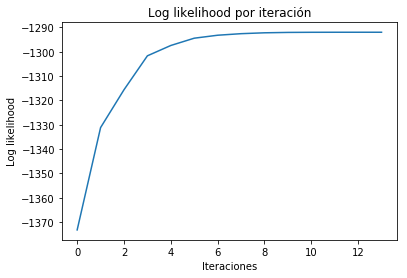

In [9]:
# Gráfico del ll
fig, ax1 = plt.subplots()
ax1.plot(EM_lls[0,0,:])
ax1.set_ylabel('Log likelihood')
ax1.set_xlabel('Iteraciones')
ax1.set_title('Log likelihood por iteración')

La probabilidad de error estimada es de 0.000000


/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/home/cecilia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Text(0,0.5,'Formante 2 [Hz]')

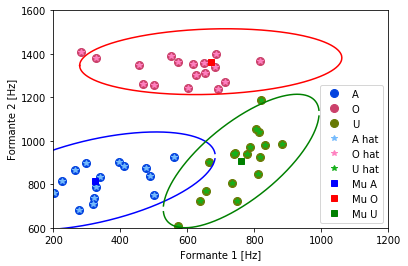

In [10]:
# Testeo de los parámeros obtenidos
# Armado del conjunto de test
formantes_test=np.vstack((formantes_a[-test_size:,:],formantes_o[-test_size:,:],formantes_u[-test_size:,:]))
c_test=np.zeros(test_size*3)
# Calculo de los gamma test
EM_gamma_test = np.zeros([test_size*3,3])
EM_gamma_test[:,0] = EM_pi[0] * sd.multivariate_normal.pdf(formantes_test, EM_mean[:,0], EM_sigma[:,:,0])
EM_gamma_test[:,1] = EM_pi[1] * sd.multivariate_normal.pdf(formantes_test, EM_mean[:,1], EM_sigma[:,:,1])
EM_gamma_test[:,2] = EM_pi[2] * sd.multivariate_normal.pdf(formantes_test, EM_mean[:,2], EM_sigma[:,:,2])
# Clasificación en base a las responsabilidades
c_test=np.argmax(EM_gamma_test,axis=1)
# Error
# Esto lo necesitaba para calcular el orden
mu_a=EM_mean[:,0]
mu_a=mu_a.reshape(2,1)
mu_o=EM_mean[:,1]
mu_o=mu_o.reshape(2,1)
mu_u=EM_mean[:,2]
mu_u=mu_u.reshape(2,1)
# Para poder ponerle una etiqueta a las muestras voy a usar los resultados que obtuve en LDA.
# Para ordenar las muestras me fijo cual esta mas cerca del valor que obtuve en LDA
orden=np.array((np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_a*unos,axis=0)),
               np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_o*unos,axis=0)),
               np.argmin(np.linalg.norm(LDA_mean[:,0,:]-mu_u*unos,axis=0))))
Pe=(np.sum(c_test[:test_size]!=orden[0])+np.sum(c_test[test_size:test_size*2]!=orden[1])+
    np.sum(c_test[test_size*2:test_size*3]!=orden[2]))/test_size/3
print('La probabilidad de error estimada es de %f'%Pe)

# Grafico final
fig, ax1 = plt.subplots()
ax1.plot(formantes_test[:test_size,0],formantes_test[:test_size,1],'o',markersize=8,color='xkcd:blue')
ax1.plot(formantes_test[test_size:test_size*2,0],formantes_test[test_size:test_size*2,1],'o',markersize=8,color='xkcd:dark pink')
ax1.plot(formantes_test[test_size*2:test_size*3,0],formantes_test[test_size*2:test_size*3,1],'o',markersize=8,color='xkcd:olive green')
ax1.plot(formantes_test[c_test==orden[0],0],formantes_test[c_test==orden[0],1],'*',color='xkcd:sky blue')
ax1.plot(formantes_test[c_test==orden[1],0],formantes_test[c_test==orden[1],1],'*',color='xkcd:pink')
ax1.plot(formantes_test[c_test==orden[2],0],formantes_test[c_test==orden[2],1],'*',color='xkcd:green')
ax1.plot(EM_mean[0,orden[0]],EM_mean[1,orden[0]],'sb')
ax1.plot(EM_mean[0,orden[1]],EM_mean[1,orden[1]],'sr')
ax1.plot(EM_mean[0,orden[2]],EM_mean[1,orden[2]],'sg')

# Elipses
radio_elipse=2.5
x,y=elipse_from_mvariance(EM_sigma[:,:,orden[0]],radio_elipse)
ax1.plot(x+EM_mean[0,orden[0]],y+EM_mean[1,orden[0]],'b')
x,y=elipse_from_mvariance(EM_sigma[:,:,orden[1]],radio_elipse)
ax1.plot(x+EM_mean[0,orden[1]],y+EM_mean[1,orden[1]],'r')
x,y=elipse_from_mvariance(EM_sigma[:,:,orden[2]],radio_elipse)
ax1.plot(x+EM_mean[0,orden[2]],y+EM_mean[1,orden[2]],'g')


ax1.legend(('A','O','U','A hat','O hat','U hat','Mu A','Mu O','Mu U'))

# Formato
ax1.set_xlim([200,1200])
ax1.set_ylim([600,1600])
ax1.set_xlabel('Formante 1 [Hz]')
ax1.set_ylabel('Formante 2 [Hz]')

## Conclusiones
Los algoritmos de categorización se basan en muchas condiciones que hay que fijar bien para que la clasificación sea buena. Los algoritmos supervizados o y los no supervizados, pueden llegar a las mismas generalizaciones. 